In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
os.sys.path.append(os.path.dirname(os.path.abspath('.')))

# Import local modules
from src.data.generate_data import FrankeFunction
from src.models.models import Ridge
from src.evaluation.evaluation import mse, r_squared
from src.resampling.resampling import K_fold_splitter

In [2]:
df_X = pd.read_csv('../data/generated/X.csv', index_col=0)
df_z_no_noise = pd.read_csv('../data/generated/no_noise.csv', usecols=[1])
df_z_some_noise = pd.read_csv('../data/generated/some_noise.csv', usecols=[1])
df_z_noisy = pd.read_csv('../data/generated/noisy.csv', usecols=[1])

X = np.array(df_X)
z_no_noise = np.array(df_z_no_noise).ravel()
z_some_noise = np.array(df_z_some_noise).ravel()
z_noisy = np.array(df_z_noisy).ravel()

In the following cell, we perform cross-validation on all the three datasets in order to find best values for the lambda hyperparameter in ridge regression

In [3]:
k = 10 # Number of folds, for cross-validation
min_lambda = 0
max_lambda = 1
no_lambdas = 100
lambda_values = list(np.linspace(min_lambda, max_lambda, no_lambdas))
targets = [{
    'name': 'No noise',
    'values': z_no_noise,
    'mse_values': np.zeros(no_lambdas)
},
{
    'name': 'Some noise (sigma 0.1)',
    'values': z_some_noise,
    'mse_values': np.zeros(no_lambdas)
},
{
    'name': 'Noisy (sigma 0.4)',
    'values': z_noisy,
    'mse_values': np.zeros(no_lambdas)
}]

col_names = ['MSE']
output_df = pd.DataFrame(columns=col_names)
# print('%-30s|%-10s' %('', 'MSE'))

# print('-'*50)

for target in targets:
    for l, lambda_value in enumerate(lambda_values):
        # print('Lambda', lambda_value)
        mse_values = np.zeros(k)
        z = target['values']
        ridge = Ridge(lambda_value)
    
        kfs = K_fold_splitter(X.shape[0], k)
        fold_indices = kfs.cross_val_split()
    
        for j, fold in enumerate(fold_indices):     
            X_train = X[fold['train_indices']]
            z_train = z[fold['train_indices']]
            X_test = X[fold['test_indices']]
            z_test = z[fold['test_indices']]
        
            ridge.fit(X_train, z_train)
            predictions = ridge.predict(X_test)
            mean_squared_error = mse(z_test, predictions)
        
            mse_values[j] = mean_squared_error
    
        mse_value = np.mean(mse_values)
        target['mse_values'][l] = mse_value
        # print('%-30s|%-10f' %(target['name'], mse_value))
        # output_df = output_df.append(pd.DataFrame(data=[[mse_value]], columns=col_names, index=[target['name']]))


We plot our results:

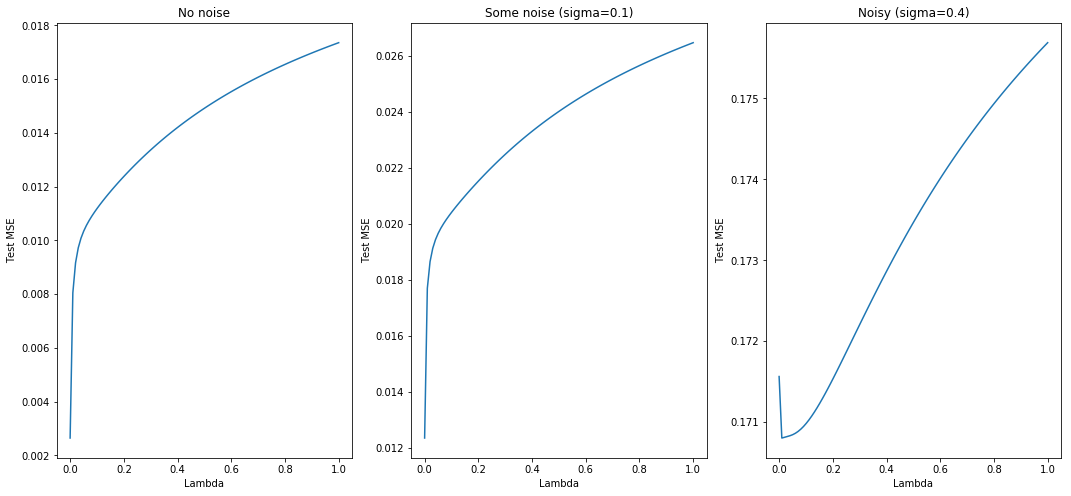

In [4]:
plt.figure(figsize=(18, 8))
plt.subplot(131)
plt.plot(lambda_values, targets[0]['mse_values'])
plt.title('No noise')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.subplot(132)
plt.plot(lambda_values, targets[1]['mse_values'])
plt.title('Some noise (sigma=0.1)')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.subplot(133)
plt.plot(lambda_values, targets[2]['mse_values'])
plt.title('Noisy (sigma=0.4)')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.show()

As we can see, only the noisy dataset seems to have an optimal lambda value other than zero. We can confirm this by getting the minimum values:

In [5]:
print('%-40s%-10s%-10s' %('Data', 'Best MSE', 'Best lambda'))
print('-'*60)
for target in targets:
    min_index = np.argmin(target['mse_values'])
    min_mse = target['mse_values'][min_index]
    best_lambda = lambda_values[min_index]
    print('%-40s%-10.5f%-10.5f' %(target['name'], min_mse, best_lambda))

Data                                    Best MSE  Best lambda
------------------------------------------------------------
No noise                                0.00264   0.00000   
Some noise (sigma 0.1)                  0.01235   0.00000   
Noisy (sigma 0.4)                       0.17080   0.01010   


In order to compare with OLS, we want to compute the test MSE of the noisy dataset when lambda is set to 0:

In [6]:
print('When lambda is zero, the test MSE of the noisy dataset is {}'.format(targets[2]['mse_values'][0]))

When lambda is zero, the test MSE of the noisy dataset is 0.17156365098062085


We also plot the test MSE of the noisy dataset against lambda one more time, in order to include it in the final report:

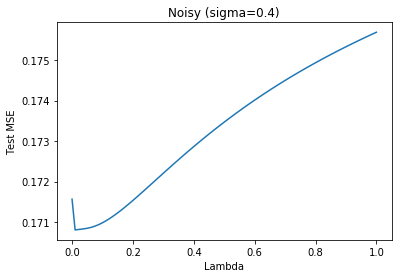

In [7]:
plt.plot(lambda_values, targets[2]['mse_values'])
plt.title('Noisy (sigma=0.4)')
plt.xlabel('Lambda')
plt.ylabel('Test MSE')
plt.savefig('../reports/figures/4_test_mse_noisy_ridge.png')
plt.show()